# Download Lidar Tilesets and Perform MR classifcation

In [39]:
import src.modules.utils as util
import random
import src.modules.MultipleReturnsClassification as MRC
import time
import pptk
import numpy as np
import seaborn as sns 
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from pyproj import Transformer
import laspy
import os
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score # How best can we seperate clusters

In [40]:
#record start time of script
script_start = time.time()

In [41]:
#Get list of files from ftp server
filenames = util.FTP_GetFileList(2017)

#Select a file at random
Random_lasFile_idx = random.randrange(len(filenames))
Random_lasFilename = filenames[Random_lasFile_idx]

print("Filename : ", Random_lasFilename)

Filename :  917135.las


In [86]:
# Download Las File to hard disk
las_fileID = 25192 #int(''.join(c for c in Random_lasFilename if c.isdigit())) 
#Testing : List in Hardisk - 15212, 25192, 47217, 47219, 987210 - Empire State, 45172 - Laguardia
year = 2017

Filename = str(las_fileID)+'.las' #Random_lasFilename #str(las_fileID)+'.las'
External_Disk_Path = '/Volumes/Elements/Terravide/Datasets/FTP_files/LiDAR/'
util.FTP_download_lasfile(Filename,year,folderpath=External_Disk_Path)

File Exists


In [90]:
#Check if output exist

CSV_loc = []
CSV_SUBTILE_EPS_Arr = []

FilesCompletedPath = '/Volumes/Elements/Terravide/Datasets/Package_Generated/MR_JSON_Files/2017/'
dir_list = os.listdir(FilesCompletedPath)

#print("Files and directories in '", FilesCompletedPath, "' :")
 
# prints all files
#print(dir_list)

las_fileID_Completed = []
for fc in dir_list:
    las_fileID_in_dir_list = ''.join(c for c in fc if c.isdigit())[:-4]

    las_fileID_Completed.append(las_fileID_in_dir_list)

#print(las_fileID_Completed)
if str(las_fileID) in las_fileID_Completed:
    print("Processing Completed for :",las_fileID)
else:
    print("file not found in completed dir")

['25192', '915125', '10137', '10140', '10142', '10145', '10147', '10150', '10152', '10155', '10157', '10160', '10162', '10165', '10167', '10172', '10175', '10177', '10180', '10182', '10185', '10187', '10190', '10192', '10195', '10197', '10200', '10202', '10205', '10207', '10210', '10212', '10215', '10217', '10220']
Processing Completed for : 25192


In [ ]:
"""
Wierd buffer read error with certain files

VALUE ERROR : buffer size must be a multiple of element size

BLACKLISTING FOR NOW
"""

BLACKLIST_FILEIDs = [10170]

# Create Las Object

In [91]:
#Object to handle las preprocessing
LasHandling = MRC.LFP

lasfilepath = External_Disk_Path+'NYC_'+str(year)+'/'+str(las_fileID)+'.las'

#Read las file
lasfile_object = LasHandling.Read_lasFile(lasfilepath)

In [17]:
TileDivision = 12
rows, cols = (TileDivision, TileDivision)

#Create Dataframe from lasfile
lidar_df, rawpoints = LasHandling.Create_lasFileDataframe(lasfileObject=lasfile_object)

#Divide lidar_df into smaller portion for development
portion_size = 100 # 1-100 %
lidar_df = lidar_df.head(int(len(lidar_df)*(portion_size/100)))

#sanity check
#pptk.viewer(lidar_df.iloc[:,:3].to_numpy())

# Extracting Ground points

In [36]:
#Taking a smaller portion of the lidar tile

lidar_df, rawpoints = LasHandling.Create_lasFileDataframe(lasfileObject=lasfile_object)


X_max_G , X_min_G = lidar_df.X.max(), lidar_df.X.min()
Y_max_G , Y_min_G = lidar_df.Y.max(), lidar_df.Y.min()

X_plane_tile_divisor_G = 60 #in m - indicates the number of tiles you want to divide the tiles into
Y_plane_tile_divisor_G = 60 #in m

X_diff_G = X_max_G - X_min_G
Y_diff_G = Y_max_G - Y_min_G

#X_div_len = math.ceil(X_diff_G/X_plane_tile_divisor_G) #introduced a margin of error at boundaries
#Y_div_len = math.ceil(Y_diff_G/Y_plane_tile_divisor_G)
X_div_len_G = X_diff_G/X_plane_tile_divisor_G
Y_div_len_G = Y_diff_G/Y_plane_tile_divisor_G

# Create 2D Matrix
rows, cols = (X_plane_tile_divisor_G, Y_plane_tile_divisor_G)
lidar_subset_df = [[0]*cols]*rows

###

Potential_Ground_Points = []
Other_points = []
max_count = X_plane_tile_divisor_G*Y_plane_tile_divisor_G


#Iterating through each tile
Tilecounter = 0

for row in range(X_plane_tile_divisor_G):
    for col in range(Y_plane_tile_divisor_G):
        Tilecounter = Tilecounter + 1
        print("Tile Number : ",Tilecounter)

        x_cloud_subset_min = X_min_G + row*X_div_len_G
        x_cloud_subset_max = X_min_G + row*X_div_len_G + X_div_len_G
        y_cloud_subset_min = Y_min_G + col*Y_div_len_G
        y_cloud_subset_max = Y_min_G + col*Y_div_len_G + Y_div_len_G
        lidar_subset_df[row][col] = lidar_df[ #Store each subset of the tile
            (lidar_df['X'].between(x_cloud_subset_min, x_cloud_subset_max, inclusive=False) &
        lidar_df['Y'].between(y_cloud_subset_min, y_cloud_subset_max, inclusive=False))
        ]

        #select rows from lidar subset df
        tile_segment_points = lidar_subset_df[row][col].iloc[:,:3].to_numpy()

        #Ground Seperation

        #Finding lowest points in the segemnt
        ground_H_thresh = 2 #height threshold in meters
        z_values = tile_segment_points[:,2]
        
        if (len(z_values) != 0):
            z_min = np.min(z_values)
            # #get K smallest values
            # smallest_K = np.sort(z_values)
            # #take avg
            # z_avg = np.mean(smallest_K)
            ground_H_thresh_perc = 0.1
            Z_Height_thresh = z_min*ground_H_thresh_perc

            lowest_points_idx = [idx for idx,record in enumerate(z_values) if record > (z_min) and record < (z_min+Z_Height_thresh) ]
            lowest_points = tile_segment_points[lowest_points_idx]

            Other_points_idx =  [idx for idx,record in enumerate(z_values) if record > (z_min+Z_Height_thresh) ]
            Not_ground_points = tile_segment_points[Other_points_idx]
            

            for k in lowest_points:
                Potential_Ground_Points.append(k) #append points which may be potentially ground points
            for l in Not_ground_points:
                Other_points.append(l)

Potential_Ground_Points_array = np.array(Potential_Ground_Points)
Potential_Other_Points_array = np.array(Other_points)

GPoints_df = pd.DataFrame(Potential_Ground_Points_array , columns=['X','Y','Z'])
NGPoints_df = pd.DataFrame(Potential_Other_Points_array , columns=['X','Y','Z'])

Tile Number :  1
Tile Number :  2
Tile Number :  3
Tile Number :  4
Tile Number :  5
Tile Number :  6
Tile Number :  7
Tile Number :  8
Tile Number :  9
Tile Number :  10
Tile Number :  11
Tile Number :  12
Tile Number :  13
Tile Number :  14
Tile Number :  15
Tile Number :  16
Tile Number :  17
Tile Number :  18
Tile Number :  19
Tile Number :  20
Tile Number :  21
Tile Number :  22
Tile Number :  23
Tile Number :  24
Tile Number :  25
Tile Number :  26
Tile Number :  27
Tile Number :  28
Tile Number :  29
Tile Number :  30
Tile Number :  31
Tile Number :  32
Tile Number :  33
Tile Number :  34
Tile Number :  35
Tile Number :  36
Tile Number :  37
Tile Number :  38
Tile Number :  39
Tile Number :  40
Tile Number :  41
Tile Number :  42
Tile Number :  43
Tile Number :  44
Tile Number :  45
Tile Number :  46
Tile Number :  47
Tile Number :  48
Tile Number :  49
Tile Number :  50
Tile Number :  51
Tile Number :  52
Tile Number :  53
Tile Number :  54
Tile Number :  55
Tile Number :  56
T

In [37]:
# import src.modules.LasFilePreprocessing as LFP
# import src.modules.ExtractGroundPlane as GP

# print("Ground Plane Classifcation Algorithm")

# TileDivision_GroundAlgo = 30 #test purposes
# rows, cols = (TileDivision_GroundAlgo, TileDivision_GroundAlgo)

# lidar_df_GroundAlgo, rawpoints_GroundAlgo = LFP.Create_lasFileDataframe(lasfileObject=lasfile_object)

# MR_df_GroundAlgo = LFP.Get_MRpoints(lidar_df_GroundAlgo)
# SR_df_GroundAlgo = LFP.Get_SRpoints(lidar_df_GroundAlgo)

# #lasTile class
# TileObj_GroundAlgo = LFP.lasTile(SR_df_GroundAlgo,TileDivision_GroundAlgo)

# #Serialized
# s_start = time.time()
# lidar_TilesubsetArr = TileObj_GroundAlgo.Get_subtileArray()

# s_end = time.time()
# stime = s_end - s_start
# print("Extraction of Subtile Matrix Buffer Serial Time : ",stime)

In [38]:
# #Ground Plane Classifcation - Serial Implementation
# g_start = time.time()
# Potential_Ground_Points = []
# Other_points = []

# GP_obj = GP.GP_class()

# for row in range(TileDivision_GroundAlgo):
#     for col in range(TileDivision_GroundAlgo):

#         tile_segment_points_G = lidar_TilesubsetArr[row][col].iloc[:,:3].to_numpy()

#         Ground_Points, NotGroundPoints = GP_obj.Extract_GroundPoints(tile_segment_points_G)

#         for k in Ground_Points:
#             Potential_Ground_Points.append(k) #append points which may be potentially ground points
        
#         for l in NotGroundPoints:
#             Other_points.append(k) #append points which may be potentially ground points

# g_end = time.time()
# gtime = g_end - g_start
# print("Ground Point Extraction Algorithm Serial Time : ",gtime)

In [39]:
#plotting tree poitns found
p1 = Potential_Ground_Points_array
p2 = Potential_Other_Points_array
All_points_1 = np.concatenate((p1, p2), axis=0)
rgb_p2 =  [[255,255,255]]*len(p2) #Set white colour - Not Ground
rgb_p1 = [[1,0,0]]*len(p1) #set red colour - Ground
All_rgb = np.concatenate((rgb_p1, rgb_p2), axis=0)

v = pptk.viewer(All_points_1, All_rgb)
v.set(show_grid=False)
v.set(show_axis=False)
v.set(bg_color = [0,0,0,0])
v.set(point_size = 0.04)

# Las Preprocessing - Implementing a Z limit

In [18]:
Tree_Height_Limit = 80 # in m
lidar_df_ZLimited  = lidar_df[lidar_df.Z < Tree_Height_Limit]

lidar_df = lidar_df_ZLimited
#pptk.viewer(lidar_df.iloc[:,:3].to_numpy())

# Creating LidarTileSubset Array

In [19]:
#Extract MR and SR points from Dataframe
MR_df = LasHandling.Get_MRpoints(lidar_df)
SR_df = LasHandling.Get_SRpoints(lidar_df)

#lasTile class
TileObj_SR = MRC.MR_class(SR_df,TileDivision) #Single Return Points
TileObj_MR = MRC.MR_class(MR_df,TileDivision) #Multiple Return Points

#Serialized Creation of Lidar Subtiles
lidar_TilesubsetArr = TileObj_MR.Get_subtileArray()

# type(lidar_TilesubsetArr[0][0]) -> pandas.core.frame.DataFrame
# [[0]*self.cols for _ in range(self.rows)]

#---------------------------------------------------------------------

# #sanity check
# temp_segmentPoints = lidar_TilesubsetArr[1][0].iloc[:,:3].to_numpy()
# pptk.viewer(temp_segmentPoints)

# #MR points plot
# pptk.viewer(MR_df.iloc[:,:3].to_numpy())

# #SR points plot
# pptk.viewer(SR_df.iloc[:,:3].to_numpy())

# Get Approximate Location of tile

In [20]:
#Print Lat , Long
ix, iy = np.mean(MR_df.X.to_numpy()), np.mean(MR_df.Y.to_numpy()) 

transformer = Transformer.from_crs("epsg:2263", "epsg:4326")
lat, lon = transformer.transform(ix*3.28, iy*3.28)
print(str(lat)+","+str(lon))

40.74636428613692,-73.98337263013039


## Tuning Hyperparameters

In [24]:
def Get_eps_NN_KneeMethod(cluster_df, N_neighbors = 12, display_plot=False):

    nearest_neighbors = NearestNeighbors(n_neighbors=N_neighbors)
    neighbors = nearest_neighbors.fit(cluster_df)
    distances, indices = neighbors.kneighbors(cluster_df)
    distances = np.sort(distances[:,N_neighbors-1], axis=0)

    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    if (display_plot):
        fig = plt.figure(figsize=(5, 5))
        knee.plot_knee()
        plt.xlabel("Points")
        plt.ylabel("Distance")
        print(distances[knee.knee])
    
    return distances[knee.knee]

def Normalize_points(points):
    return points / np.linalg.norm(points)

#Note : Not Used in Current workflow
def Get_Optimal_MinSamples(points,ep,start=20,end=70,step=10):

    range_min_samples = np.arange(start, end, step)

    S_score_min_samples_hashmap = {} # S_score -> min_samples

    for m in range_min_samples :
                
        db = DBSCAN(eps=ep, min_samples=m).fit(points)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        #print(set(labels))
        if(len(set(labels))) < 2 :
             return (1.5,0)
        silhouette_avg = silhouette_score(points, labels)
        print("For eps value = ",ep,"; Min Samples = ",m, "The average silhouette_score is :", silhouette_avg)

        if silhouette_avg not in S_score_min_samples_hashmap:
            S_score_min_samples_hashmap[silhouette_avg] = ep
        
        Best_min_samples = S_score_min_samples_hashmap[max(S_score_min_samples_hashmap)]
    
    return (Best_min_samples, max(S_score_min_samples_hashmap))

# Plot EPS variations on tile

EPS :  1.8401344473111838


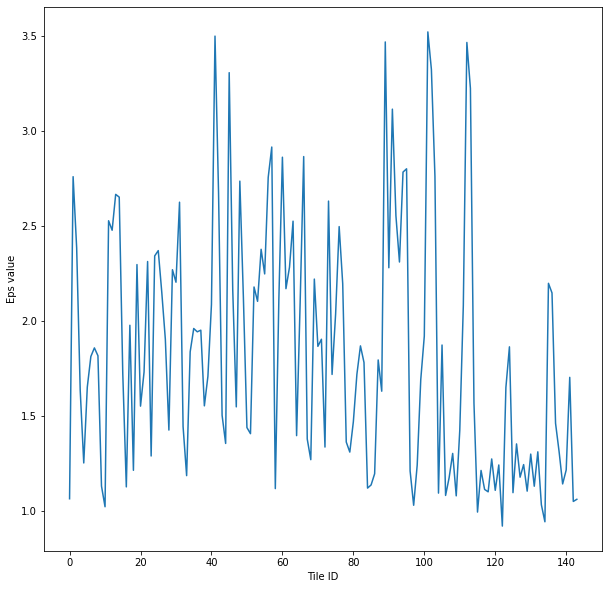

In [25]:
All_eps = [] #Stores all eps values by tile id
N_Neighbours = 12
for row in range(TileDivision):
    for col in range(TileDivision):

        if(len(lidar_TilesubsetArr[row][col].iloc[:,:3].to_numpy()) > N_Neighbours):

            cluster_df = lidar_TilesubsetArr[row][col].iloc[:,:3]

            tile_eps = Get_eps_NN_KneeMethod(cluster_df)

            All_eps.append(tile_eps)

# fig = plt.figure(figsize=(10, 10))
# plt.plot(All_eps)
# plt.xlabel("Tile ID")
# plt.ylabel("Eps value")

Optimal_EPS = np.mean(All_eps)
print("EPS : ",Optimal_EPS)


In [75]:
#write eps distribution to csv

CSV_loc.append([lat, lon])
CSV_SUBTILE_EPS_Arr.append(All_eps)

Spatial_HP_df = pd.DataFrame({"las_fileID" : las_fileID, "Tile_Location" : CSV_loc,
                "EPS_variations" : CSV_SUBTILE_EPS_Arr})

Spatial_HP_df.to_csv('Spatial_HP_Distribution.csv')

# Classifying only Tree points from Multiple Returns

In [93]:
# Classify tree points in MR without extracting tree clusters

Tilecounter = 0
Trees_Buffer = []

for row in range(TileDivision):
    for col in range(TileDivision):

        print('-'*40)
        
        print("TILE ID : ",Tilecounter)
        Tilecounter = Tilecounter + 1

        if (len(lidar_TilesubsetArr[row][col].iloc[:,:3].to_numpy()) > N_Neighbours):

            cluster_df = lidar_TilesubsetArr[row][col].iloc[:,:3]

            tile_eps = Get_eps_NN_KneeMethod(cluster_df) #round(Optimal_EPS,2)
            print(tile_eps)

            tile_segment_points = lidar_TilesubsetArr[row][col].iloc[:,:3].to_numpy()

            subTileTree_Points,  _ = TileObj_MR.Classify_MultipleReturns(tile_segment_points,tile_eps)

            for t in subTileTree_Points:
                Trees_Buffer.append(t)
            
            print("Trees added")
        
        else:
            print("empty tileset found")

Trees_Buffer = np.array(Trees_Buffer)

#pptk.viewer(Trees_Buffer)

----------------------------------------
TILE ID :  0
1.0646924662024901
Trees added
----------------------------------------
TILE ID :  1
2.759356884572277
Trees added
----------------------------------------
TILE ID :  2
2.3854228227972856
Trees added
----------------------------------------
TILE ID :  3
1.6352721822658436
Trees added
----------------------------------------
TILE ID :  4
1.2530376534999403
Trees added
----------------------------------------
TILE ID :  5
1.6522196326513399
Trees added
----------------------------------------
TILE ID :  6
1.8132146173446289
Trees added
----------------------------------------
TILE ID :  7
1.8583686348021666
Trees added
----------------------------------------
TILE ID :  8
1.8172163963482446
Trees added
----------------------------------------
TILE ID :  9
1.1314426532940574
Trees added
----------------------------------------
TILE ID :  10
1.0225647934155992
Trees added
----------------------------------------
TILE ID :  11
2.52742431

In [96]:
#plotting tree poitns found
p1 = Trees_Buffer
p2 = MR_df.iloc[:,:3].to_numpy()
All_points_1 = np.concatenate((p1, p2), axis=0)
rgb_p2 =  [[1,0,0]]*len(p2) #Set red colour
rgb_p1 = [[0,1,0]]*len(p1) #set green colour - Classified tree points
All_rgb = np.concatenate((rgb_p1, rgb_p2,), axis=0)

v = pptk.viewer(All_points_1, All_rgb)
v.set(show_grid=False)
v.set(show_axis=False)
v.set(bg_color = [0,0,0,1])
v.set(point_size = 0.04)


x_mean = np.mean(p2[:,0])
y_mean = np.mean(p2[:,1])
z_mean = np.mean(p2[:,2])

v.set(phi=np.pi/4)
v.set(theta=np.pi/6)
v.set(r=900)
v.set(lookat=[x_mean,y_mean,0])


pptk_capture_path = "/Volumes/Elements/TerraVide/Datasets/" + "Package_Generated/PPTK_screenshots/"
v.capture(pptk_capture_path+"Capture"+str(las_fileID)+"_"+str(year)+'.png')

v.close()

# Extracting Tree Clusters from Multiple Returns

### Tree Census
---

In [18]:
#TODO : Make a function for this

# Tree Census
Trees_found_in_Tile = True

path = "/Volumes/Elements/Terravide/Datasets/NYC_Tree_Dataset/2015StreetTreesCensus_TREES.csv"
Tree_Dataset = pd.read_csv(path)
las = laspy.read(lasfilepath) # .las file taken from NYC topbathymetric 2017 Lidar data

point_format = las.point_format
lidarPoints = np.array((las.X,las.Y,las.Z,las.intensity,las.classification, las.return_number, las.number_of_returns)).transpose()
lidar_dfRead = pd.DataFrame(lidarPoints)
# correct XYZ scale to state plane
lidar_dfRead[0] = lidar_dfRead[0]/100
lidar_dfRead[1] = lidar_dfRead[1]/100
lidar_dfRead[2] = lidar_dfRead[2]/100
# find bounds of las file
x_min = lidar_dfRead[0].min()
x_max = lidar_dfRead[0].max()
y_min = lidar_dfRead[1].min()
y_max = lidar_dfRead[1].max()
# select trees in lidar footprint in a new dataframe
trees_df2 = Tree_Dataset.copy()
trees_df2 = trees_df2[trees_df2['x_sp']>x_min]
trees_df2 = trees_df2[trees_df2['x_sp']<x_max]
trees_df2 = trees_df2[trees_df2['y_sp']>y_min]
trees_reduced_df = trees_df2[trees_df2['y_sp']<y_max]

True_TreeLoc = {"Tree_X" : trees_reduced_df.x_sp.to_numpy(),
                "Tree_Y" : trees_reduced_df.y_sp.to_numpy()}

# Used to Map Tree ID to Predicted Tree Cluster
True_TreeLoc_X = True_TreeLoc['Tree_X']/3.28
True_TreeLoc_Y = True_TreeLoc['Tree_Y']/3.28
Tree_Census_Loc_xy = np.stack((True_TreeLoc_X,True_TreeLoc_Y),axis=1)

#Use KDTree
if (len(Tree_Census_Loc_xy) == 0):
    print("No Trees in Tree census")
    Trees_found_in_Tile = False

from scipy import spatial

if(Trees_found_in_Tile):
    Tree_Census_KDTree = spatial.KDTree(Tree_Census_Loc_xy)
else:
    #TODO : QUICK FIX - FIX Later
    simpleFixarr = [[313223.43600915,  59044.84813689],
       [313260.9461372 ,  58974.44035335],
       [313212.84671951,  59072.36252561]]
    Tree_Census_KDTree = spatial.KDTree(simpleFixarr)

In [19]:
Tilecounter = 0
Trees_Buffer = []

#JSON Buffer vars
TreeClusterID = 0
JSON_data_buffer = {
    "lasFileID" : las_fileID,
    "RecordedYear" : year,
    "MR_TreeClusterDict" : []
}

#For Ground - TODO: write into library

X_max , X_min = lidar_df.X.max(), lidar_df.X.min()
Y_max , Y_min = lidar_df.Y.max(), lidar_df.Y.min()

X_diff = X_max - X_min
Y_diff = Y_max - Y_min

X_div_len = X_diff/TileDivision
Y_div_len = Y_diff/TileDivision

rows, cols = (TileDivision, TileDivision)
lidar_subsetGround_df = [[0]*cols]*rows

for row in range(TileDivision):
    for col in range(TileDivision):

        print('-'*40)
        
        print("TILE ID : ",Tilecounter)
        print("TreeCLusterID : ",TreeClusterID)
        Tilecounter = Tilecounter + 1

        cluster_df = lidar_TilesubsetArr[row][col].iloc[:,:3]

        tile_eps = Get_eps_NN_KneeMethod(cluster_df) #round(Optimal_EPS,2)
        print("EPS :",tile_eps)

        tile_segment_points = lidar_TilesubsetArr[row][col].iloc[:,:3].to_numpy()

        #TODO : Clean code for Ground Z value

                #Ground
        lidar_subsetGround_df[row][col] = GPoints_df[ #Store each subset of the tile
            (GPoints_df['X'].between(x_cloud_subset_min, x_cloud_subset_max, inclusive=False) &
        GPoints_df['Y'].between(y_cloud_subset_min, y_cloud_subset_max, inclusive=False))
        ]

        #select ground tile segment points
        tile_segment_pointsGround = lidar_subsetGround_df[row][col].iloc[:,:3].to_numpy()
        Ground_Tile_Zvalue = np.mean(tile_segment_pointsGround[:,2])


        subTileTree_Points, _ , TreeCounterID = TileObj_MR.Get_MultipleReturnTreeCLusters(
                                    tile_segment_points,
                                    Tree_Census_KDTree,5,trees_reduced_df, #tree mapping tolerance thresh = 5 m
                                    Tilecounter,
                                    las_fileID,
                                    JSON_data_buffer,
                                    TreeClusterID,
                                    Ground_Tile_Zvalue,
                                    tile_eps)

        TreeClusterID = TreeCounterID #TODO : make global var 

        for t in subTileTree_Points:
            Trees_Buffer.append(t)
        
        print("Trees Clusters added to JSON")

Trees_Buffer = np.array(Trees_Buffer)

#pptk.viewer(Trees_Buffer)

----------------------------------------
TILE ID :  0
TreeCLusterID :  0
EPS : 1.7153475123407098
Trees Clusters added to JSON
----------------------------------------
TILE ID :  1
TreeCLusterID :  7
EPS : 1.7884131788828834
Trees Clusters added to JSON
----------------------------------------
TILE ID :  2
TreeCLusterID :  11
EPS : 1.6322682145061844
Trees Clusters added to JSON
----------------------------------------
TILE ID :  3
TreeCLusterID :  16
EPS : 1.3884576136870048
Trees Clusters added to JSON
----------------------------------------
TILE ID :  4
TreeCLusterID :  29
EPS : 1.5808860251840433
Trees Clusters added to JSON
----------------------------------------
TILE ID :  5
TreeCLusterID :  32
EPS : 1.3872487258393669
Trees Clusters added to JSON
----------------------------------------
TILE ID :  6
TreeCLusterID :  49
EPS : 1.5340819958167236
Trees Clusters added to JSON
----------------------------------------
TILE ID :  7
TreeCLusterID :  58
EPS : 1.6192985597567988
Trees C

# Save Results

### Create JSON File of MR Tree Clusters
---

In [20]:
JSONfoldernName = "MR_JSON_Files"

jpath = "/Volumes/Elements/TerraVide/Datasets/" + "Package_Generated/" + JSONfoldernName + "/" + str(year)

# Check whether the specified jpath exists or not
isExist = os.path.exists(jpath)

if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(jpath)

with open(jpath+"/"+str(las_fileID)+"_"+str(year)+"_TreeCluster.json", "w") as jsonFile:
  jsonFile.truncate(0)
  json.dump(JSON_data_buffer, jsonFile)

### Create CSV File of Ground and Non Ground Points
---

In [21]:
CSVfoldernName = "MR_CSV_Files"

csvpath = "/Volumes/Elements/TerraVide/Datasets/" + "Package_Generated/" + CSVfoldernName + "/" + str(year)

# Check whether the specified jpath exists or not
isExist = os.path.exists(csvpath)

if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(csvpath)

G_points_filepath = csvpath+"/"+str(las_fileID)+"_"+str(year)+"_GroundPoints.csv"
GPoints_df.to_csv(G_points_filepath)

NG_points_filepath = csvpath+"/"+str(las_fileID)+"_"+str(year)+"_NotGroundPoints.csv"
NGPoints_df.to_csv(NG_points_filepath)

In [22]:
#record end time of script
script_end = time.time()

print("Total Time : ",round((script_end - script_start)/60,2)," min")

Total Time :  12.78  min


---

# Below block maps distribution to hyperparameter - Maybe not needed

In [23]:


# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.cluster import DBSCAN



# from scipy.stats import ks_2samp #Check how different each distributions are

# Tilecounter = 0
# Trees_Buffer = []

# # Hashmap to store MinSamples with distribution
# MinSamples_Distribution_Hmap = {} # Df_Z -> MinSamples

# for row in range(2):
#     for col in range(4):

#         print('-'*40)
        
#         print("TILE ID : ",Tilecounter)
#         Tilecounter = Tilecounter + 1

#         cluster_df = lidar_TilesubsetArr[row][col].iloc[:,:3]

#         tile_eps = Get_Optimal_Eps(cluster_df)

#         tile_segment_points = cluster_df.to_numpy()

#         # tile_segment_points_X = lidar_TilesubsetArr[row][col].iloc[:,0].to_numpy()
#         # tile_segment_points_Y = lidar_TilesubsetArr[row][col].iloc[:,1].to_numpy()
#         # tile_segment_points_Z = lidar_TilesubsetArr[row][col].iloc[:,2].to_numpy()
        
#         if (len(tile_segment_points) > 0): #buffer has points to classify

#             if not MinSamples_Distribution_Hmap: #Dict is empty
                
#                 #find optimal MinSamples
#                 Optimal_MinSamples, S_Score = Get_Optimal_MinSamples(points=tile_segment_points, ep=tile_eps)

#                 # Mapping Z distribution -> MinSamples value,  to check KS_statistic later to compare distribution
#                 MinSamples_Distribution_Hmap[tuple(tile_segment_points[:,2])] = [Optimal_MinSamples,S_Score]
            
#             else: #Dict is not empty

#                 #Find Minimum KS statistic and check is KS statistic is less than 0.5 (arbitarily chosen)

#                 KS_stat_list = [] # Empty list for each tile to compare KS statistic as seen from previous tiles
#                 min_KS_stat_info = [100,-1] #[KS_stat, Key of dict after comparison] #default 100,-1

#                 for k in MinSamples_Distribution_Hmap.keys() : 

#                     z1 = Normalize_points(k) # get Z_points from dict
#                     z2 = Normalize_points(tile_segment_points[:,2]) # get Z_points from new tile

#                     cur_statistic, pvalue = ks_2samp(z1, z2) #compare

#                     #Logs
#                     # print(f'K-S statistic (z): {cur_statistic:.3f}')
#                     # print(f'p-value (z): {pvalue:.3f}')

#                     #if pvalue < 0.05: #p < 0.05 , # NOTE: Not sure to include, maybe identical buildings?
#                     KS_stat_list.append(cur_statistic) #add to list

#                     if cur_statistic < min_KS_stat_info[0]:
#                         #update best distribution
#                         min_KS_stat_info[0] = cur_statistic
#                         min_KS_stat_info[1] = k
                
#                 print("KS Stat : ",min_KS_stat_info[0])

#                 #NOTE : #if KS_statistic is significant (high) it represents that the 2 disttribtuions are very Different and likely drawn from different distributions

#                 if min_KS_stat_info[0] < 0.6: 

#                     #get optimal MinSamples from best matching distribution

#                     Optimal_MinSamples, S_Score = MinSamples_Distribution_Hmap[min_KS_stat_info[1]] #Get the optimal MinSamples and s_score by passing key (df_z values) of best match (low KS)
#                 else:

#                     #Recalculate MinSamples and add it to hashmap 

#                     #find optimal MinSamples
#                     Optimal_MinSamples, S_Score = Get_Optimal_MinSamples(tile_segment_points)

#                     # Mapping Z distribution -> MinSamples value,  to check KS_statistic later to compare distribution
#                     MinSamples_Distribution_Hmap[tuple(tile_segment_points[:,2])] = [Optimal_MinSamples,S_Score]
                       
#             # Logs
#             print("OPTIMAL MinSamples : ",Optimal_MinSamples)
            

#             subTileTree_Points,  _ = TileObj_MR.Classify_MultipleReturns(tile_segment_points, hp_eps=tile_eps, hp_min_points=Optimal_MinSamples)

#             for t in subTileTree_Points:
#                 Trees_Buffer.append(t)
            
#             print("Trees added")

# Trees_Buffer = np.array(Trees_Buffer)

# pptk.viewer(Trees_Buffer)

In [24]:
# t1 = Normalize_points(lidar_TilesubsetArr[0][0].iloc[:,:3].to_numpy())
# t2 = Normalize_points(lidar_TilesubsetArr[0][1].iloc[:,:3].to_numpy())

# sns.jointplot(t1[:,0], t1[:,1], kind='scatter')

# from scipy.stats import ks_2samp


# # Extract the x and y coordinates from the point cloud datasets
# x1 = t1[:,0]
# y1 = t1[:,1]
# z1 = t1[:,2]
# x2 = t2[:,0]
# y2 = t2[:,1]
# z2 = t2[:,2]

# # Perform the K-S test on the x coordinates
# statistic, pvalue = ks_2samp(x1, x2)
# print(f'K-S statistic (x): {statistic:.3f}')
# print(f'p-value (x): {pvalue:.3f}')

# # Perform the K-S test on the y coordinates
# statistic, pvalue = ks_2samp(y1, y2)
# print(f'K-S statistic (y): {statistic:.3f}')
# print(f'p-value (y): {pvalue:.3f}')


# #NOTE : Z value varies the most, if KS is large , there are from different distributions
# # Perform the K-S test on the z coordinates
# statistic, pvalue = ks_2samp(z1, z2)
# print(f'K-S statistic (z): {statistic:.3f}')
# print(f'p-value (z): {pvalue:.3f}')

In [25]:
# import matplotlib.pyplot as plt

# z1 = norm1[:,2]
# z2 = norm2[:,2]

# # Set up the figure and axes for the histograms
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# # Plot the histogram for the z1 norm1
# ax1.hist(z1, bins=20)
# ax1.set_xlabel('z1')
# ax1.set_ylabel('count')

# # Plot the histogram for the z2 norm2
# ax2.hist(z2, bins=20)
# ax2.set_xlabel('z2')
# ax2.set_ylabel('count')


# # Show the figure
# plt.show()
